In [1]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [2]:
# !pip install import-ipynb

In [3]:
import import_ipynb

In [4]:
# %cd /content/drive/MyDrive/A62_projet_synthese_feature/feature-colab-from-git/notebook

In [5]:
%run iteration_0_imports.py

In [6]:
%run iteration_0_parameters.py

In [7]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [8]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

In [9]:
DATE_TIME = "2021-11-18_20-39-00"

"""
PATH_SAMPLE = "data/sample"
HEALTHY = "H"
SICK = "S"
IMG_SIZE = 400
"""

'\nPATH_SAMPLE = "data/sample"\nHEALTHY = "H"\nSICK = "S"\nIMG_SIZE = 400\n'

# Modele

In [10]:
PATH_DATA_SAMPLE

'../data/sample'

In [11]:
NBR_SAMPLE

20000

In [12]:
DATE_TIME

'2021-11-18_20-39-00'

In [13]:
IMG_SIZE

64

## Split X y

In [16]:
X = utils.pickle_read(PATH_MODEL + "/" + "X.pklz")
y = utils.pickle_read(PATH_MODEL + "/" + "y.pklz")

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 0) 

In [18]:
del X
del y
gc.collect()
gc.collect()

40

## Random forest

In [21]:
model_rf = RandomForestClassifier(random_state = 0)

In [22]:
# X_train = utils.pickle_read(PATH_MODEL + "/" + "X_train_pix_normalized.pklz")
# X_test = utils.pickle_read(PATH_MODEL + "/" + "X_test_pix_normalized.pklz")

# y_train = utils.pickle_read(PATH_MODEL + "/" + "y_train_pix_normalized.pklz")
# y_test = utils.pickle_read(PATH_MODEL + "/" + "y_test_pix_normalized.pklz")

In [23]:
# fit model
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

## Obtenir les métriques

In [24]:
# create dataframe metrics
df_metrics = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred), columns = ["H", "S"], 
         index=["Precion", "Recall", "F1", "Support"])
# add average column    
df_metrics["average_macro"] = precision_recall_fscore_support(y_test, y_pred, average = "macro")
df_metrics = df_metrics.replace(np.nan, -999)
sr_metrics = df_metrics.stack(dropna=False)

df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ["cm_H", "cm_S"], index = ["cm_H", "cm_S"])
sr_confusion_matrix = df_confusion_matrix.stack()
sr_metrics = pd.concat([sr_metrics, sr_confusion_matrix])

In [25]:
df_metrics

,H,S,average_macro
Precion,0.763811,0.756783,0.760297
Recall,0.753500,0.767000,0.760250
F1,0.758621,0.761857,0.760239
Support,2000.000000,2000.000000,-999.000000


In [26]:
df_confusion_matrix

,cm_H,cm_S
cm_H,1507,493
cm_S,466,1534


## Tracker les métriques

* **N.B**:
    * **Dans un terminal lancer la commande : mlflow ui**

In [27]:
mlflow.set_experiment(experiment_name='Projet_A62')
mlflow.set_tracking_uri("http://localhost:5000")

In [28]:
with mlflow.start_run(nested=True) as run:
    for idx, val in enumerate(sr_metrics):
        mlflow.log_metric("_".join(sr_metrics.index[idx]) ,val)
    
    mlflow.sklearn.log_model(model_rf, "model")
    mlflow.set_tag("model_rf", str(model_rf))

In [30]:
# Sauvegarder le modèle
os.makedirs(PATH_MODEL, exist_ok=True)
utils.pickle_save(model_rf, PATH_MODEL + "/" + "model_rf.pklz")

### Courbe d'apprentissage

In [32]:
def spot_overfit_needed_data(model, X_train, y_train, cv = 5, scoring= "f1_macro"):

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = cv, 
                                               train_sizes =np.linspace(0.1, 1, 10),
                                                scoring = scoring)

    plt.figure(figsize=(12,8))
    plt.grid()
    axes = plt.gca()
    axes.set_ylim([0.5,1.05])
    plt.plot(N, train_score.mean(axis = 1), "o-", label = "train_score")
    plt.plot(N, val_score.mean(axis = 1)  , "o-", label = "validation_score")
    plt.legend()
    plt.show()


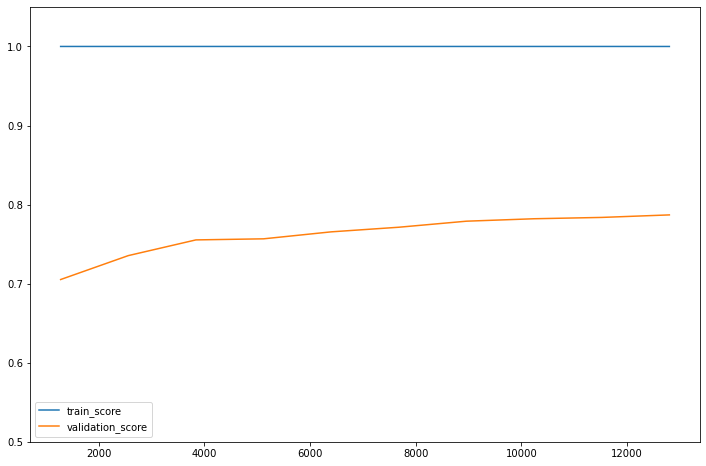

In [23]:
spot_overfit_needed_data(model_rf, X_train, y_train)